In [68]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import random

from torch.distributions.categorical import Categorical
from typing import List
from tqdm import tqdm

import sys
sys.path.insert(1, '../src')
from config import *
from alphaclass import AlphaGFN
from models import TBModel
from reward import compute_log_reward
from loss import trajectory_balance_loss

In [69]:
# Utils
def expr_sequence_to_string(expr: List[str]) -> str:
    string = ''
    stack = []
    for a in expr:
        if a in ['BEG', 'SEP']:
            continue
        elif a in FEATURES:
            stack.append(a)
        elif a in UNARY:
            operand = stack.pop()
            stack.append(a + '(' + operand + ')')
        elif a in BINARY:
            operand_2 = stack.pop()
            operand_1 = stack.pop()
            stack.append(a + '(' + operand_1 + ',' + operand_2 + ')')
        else:
            ValueError
    return stack[0]

# Training Loop

In [70]:
# Reproducibility.
seed = 2024
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# Instantiate model and optimizer
model = TBModel(num_hid_1 = 128, num_hid_2 = 128)
opt = torch.optim.Adam(model.parameters(),  learning_rate)

# Accumulate losses here and take a gradient step every `update_freq` episode (at the end of each trajectory).
losses, sampled_ics, sampled_expressions, logZs = [], [], [], []
minibatch_loss = torch.tensor([0], dtype=torch.float32)
update_freq = 20

n_episodes = 1000

alpha = AlphaGFN()

for episode in tqdm(range(n_episodes), ncols=100):
    
    alpha.reset()  # Each episode starts with an empty state and operand stack.
    P_F_s, P_B_s = model(alpha.get_tensor_state().unsqueeze(0))  # Forward and backward policy
    total_log_P_F, total_log_P_B = 0, 0

    for t in range(MAX_EXPR_LENGTH):  # All trajectories are at most length MAX_EXPR_LENGTH.

        # Here we mask the relevant forward actions.
        mask = alpha.get_forward_masks()
        P_F_s = torch.where(mask, P_F_s, torch.tensor(-100, dtype=torch.float32))  # Removes invalid forward actions.

        # Here P_F is logits, so we use Categorical to compute a softmax.
        categorical = Categorical(logits=P_F_s)
        action = categorical.sample()  # Sample the next action.
        alpha.step(action)  # Update to new state.
        total_log_P_F += categorical.log_prob(action)  # Accumulate the log_P_F sum.

        # We recompute P_F and P_B for the new state.
        P_F_s, P_B_s = model(alpha.get_tensor_state().unsqueeze(0))
        mask = alpha.get_backward_masks()
        P_B_s = torch.where(mask, P_B_s, torch.tensor(-100, dtype=torch.float32))  # Removes invalid backward actions.

        # Accumulate P_B, going backwards from new state. 
        total_log_P_B += Categorical(logits=P_B_s).log_prob(action)
        
        if alpha._action_to_token(action) == "SEP":  # End of trajectory.
            break

    if alpha._action_to_token(action) == "SEP":
        ic, log_reward = compute_log_reward(alpha.stack[0])
        if not np.isnan(log_reward):
            minibatch_loss += trajectory_balance_loss(
                model.logZ,
                total_log_P_F,
                total_log_P_B,
                log_reward = torch.tensor(log_reward, dtype=torch.float32),
            )

            sampled_expressions.append([alpha._action_to_token(action) for action in alpha.state])
            sampled_ics.append(ic) 
        
    if episode > 0 and episode % update_freq == 0 and minibatch_loss:
        losses.append(minibatch_loss.item())
        logZs.append(model.logZ.item())
        minibatch_loss.backward()
        opt.step()
        opt.zero_grad()
        minibatch_loss = 0


100%|███████████████████████████████████████████████████████████| 1000/1000 [41:55<00:00,  2.52s/it]


# Examine training results

**Since we only trained for 1000 episodes here, the model has not been optimized at all. The following code chunks are only for illustration purpose!**

## Loss curve and estimated partition function over time

In a propoerly trained model that has sufficient exploration, the loss should decrease over time and estimated partition function Z should reach a plateau.

Text(0.5, 0.98, 'Loss and Estimated Partition Function for the Trajectory Balance Model')

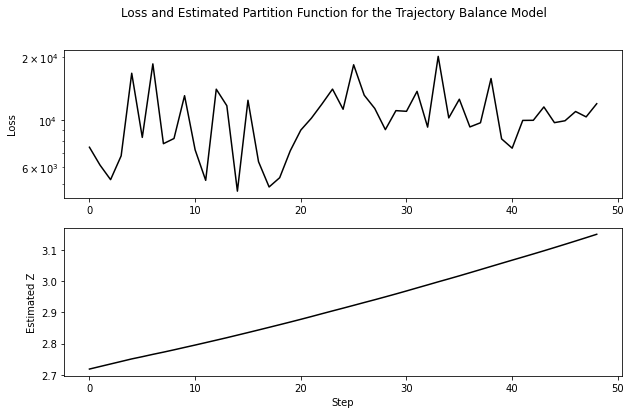

In [71]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plt.sca(ax[0])
plt.plot(losses, color="black")
plt.yscale('log')
plt.ylabel('Loss')
plt.sca(ax[1])
plt.plot(np.exp(logZs), color="black")
plt.ylabel('Estimated Z');
plt.xlabel('Step')
plt.suptitle("Loss and Estimated Partition Function for the Trajectory Balance Model")

## Example expressions and their IC

In [72]:
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.html.use_mathjax', False)
res = pd.DataFrame(
    {'expr': [expr_sequence_to_string(ex) for ex in sampled_expressions], 'ic': sampled_ics}
).sort_values(by='ic')
res

,expr,ic
493,"ops_divide(ops_subtract(ops_divide(ops_add(ops_subtract(ops_divide($open,ops_roll_std($volume)),$open),ops_roll_std($close)),ops_abs($high)),$close),$open)",-0.018810
404,"ops_roll_std(ops_roll_std(ops_divide(ops_add(ops_abs($volume),ops_abs($open)),$volume)))",-0.017378
399,"ops_roll_std(ops_multiply(ops_add(ops_subtract(ops_divide(ops_roll_corr($high,$open),$open),$low),$open),$open))",-0.016817
736,"ops_abs(ops_divide(ops_multiply(ops_abs(ops_roll_corr($open,$open)),ops_abs(ops_roll_std(ops_abs($open)))),$volume))",-0.016738
269,"ops_divide(ops_subtract(ops_add(ops_subtract(ops_subtract(ops_roll_std(ops_divide(ops_roll_std($open),$volume)),$high),$volume),$high),ops_roll_std(ops_roll_std($open))),$open)",-0.016213
...,...,...
448,"ops_abs(ops_subtract(ops_divide(ops_subtract(ops_divide(ops_log($high),ops_roll_std(ops_roll_std($low))),$volume),$open),$close))",0.016005
606,"ops_subtract(ops_divide(ops_subtract(ops_abs($volume),ops_abs(ops_roll_std(ops_log($volume)))),$high),$high)",0.016217
577,"ops_roll_std(ops_subtract(ops_divide(ops_divide(ops_abs($volume),ops_roll_std(ops_roll_std($open))),ops_roll_std($close)),$high))",0.016481
824,"ops_add(ops_multiply(ops_abs(ops_divide(ops_roll_corr($open,ops_log($open)),ops_abs(ops_roll_std($open)))),$volume),$open)",0.016710


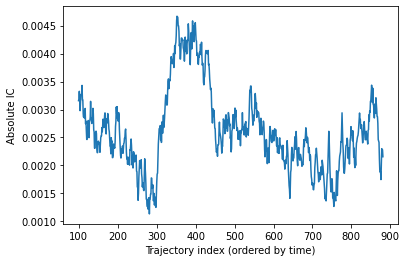

In [73]:
# Reset index to create a new column with original index values
res['original_index'] = res.index
res0 = res.sort_values(by='original_index')
ic_ma = res0['ic'].rolling(window=100).mean()
plt.plot(range(len(ic_ma)), np.abs(ic_ma), label='Line')
plt.xlabel('Trajectory index (ordered by time)')
plt.ylabel('Absolute IC')
plt.show()

array([[<AxesSubplot:title={'center':'ic'}>]], dtype=object)

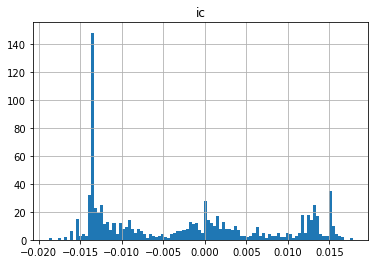

In [74]:
res.hist('ic', bins=100)

## Zooming-in: groups of expressions with high absolute ICs 

In [75]:
## Negative IC
# IC < -0.01
expr_g1 = [sampled_expressions[i] for i, ic in enumerate(sampled_ics) if ic < -0.01]
act_g1  = [a for expr in expr_g1 for a in expr]
## Positive IC
# IC >= 0.01
expr_g2 = [sampled_expressions[i] for i, ic in enumerate(sampled_ics) if ic >= 0.01]
act_g2  = [a for expr in expr_g2 for a in expr]


In [76]:
from collections import Counter
count_g1 = Counter(act_g1).most_common()
count_g2 = Counter(act_g2).most_common()

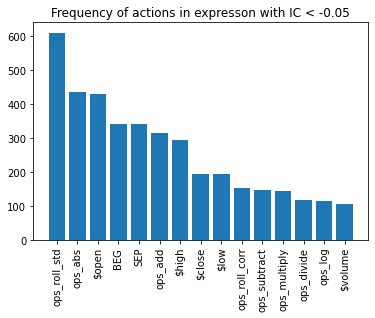

In [77]:
labels, counts = zip(*count_g1)
plt.bar(labels, counts); plt.xticks(rotation=90)
plt.title('Frequency of actions in expresson with IC < -0.05')
plt.show()

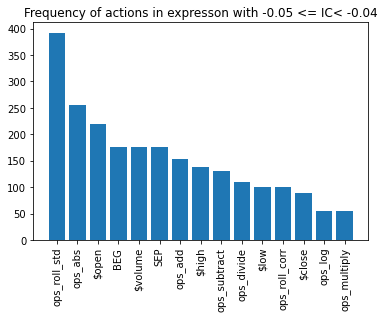

In [78]:
labels, counts = zip(*count_g2)
plt.title('Frequency of actions in expresson with -0.05 <= IC< -0.04')
plt.bar(labels, counts); plt.xticks(rotation=90); plt.show()

## Zooming-in: Groups of expressions with low absolute ICs 

In [79]:
# |IC| < 0.005
expr_g3 = [sampled_expressions[i] for i, ic in enumerate(sampled_ics) if np.abs(ic) < 0.005]
act_g3  = [a for expr in expr_g3 for a in expr]

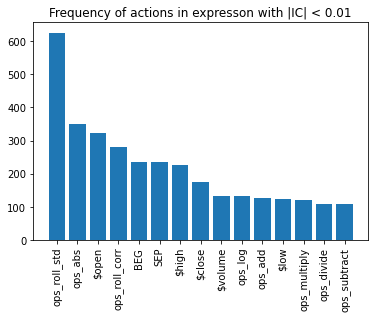

In [80]:
count_g3 = Counter(act_g3).most_common()
labels, counts = zip(*count_g3)
plt.bar(labels, counts); plt.xticks(rotation=90)
plt.title('Frequency of actions in expresson with |IC| < 0.01')
plt.show()